In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns
import scipy 

import random

import pandas as pd 
import os 
from tqdm import tqdm 

import cv2 
from PIL import Image

import tensorflow as tf 
from tensorflow.keras import models, layers 

train_depth_left = "../Datasets/stereo/data_scene_flow/training/disp_occ_0"
train_depth_right = "../Datasets/stereo/data_scene_flow/training/disp_occ_1"
train_img_left = "../Datasets/stereo/data_scene_flow/training/image_2"
train_img_right = "../Datasets/stereo/data_scene_flow/training/image_3"

test_img_left = "../Datasets/stereo/data_scene_flow/testing/image_2"
test_img_right = "../Datasets/stereo/data_scene_flow/testing/image_3"

train_paths = [train_depth_left, train_depth_right, train_img_left, train_img_right]
test_paths = [None, None, test_img_left, test_img_right]

In [2]:
tf.config.list_physical_devices("GPU")

2021-10-29 18:43:03.616351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 18:43:03.622570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 18:43:03.622879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

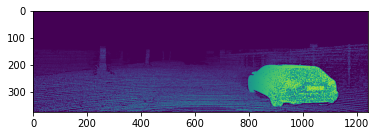

In [3]:
depth_path = "../Datasets/stereo/data_scene_flow/training/disp_occ_0/000018_10.png"
depth_map = np.asarray(Image.open(depth_path)) 
plt.imshow(depth_map)
plt.show()

In [4]:
HEIGHT, WIDTH = np.asarray(Image.open(depth_path)).shape
print(HEIGHT, WIDTH)

HEIGHT = 224
WIDTH = 224

375 1242


In [5]:
# model ... 

# datagen = DataLoader(train_paths)
# for epoch in range(epochs):

#     batch = datagen.getBatch()      #32 

In [6]:
class SupervisedDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True):
        self.data=df 
        self.batch_size = batch_size
        self.idx = self.data.index.tolist() 
        self.dim = dim 
        self.channels = n_channels 
        self.shuffle = shuffle 
        self.min_depth = 0.1 
        self.on_epoch_end() 

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size)) 

    def __getitem__(self, idx):
        if(idx+1) * self.batch_size > len(self.idx):
            self.batch_size = len(self.idx) - idx*self.batch_size 

        idx = self.idx[idx * self.batch_size : (idx+1)*self.batch_size] 
        batch = [self.idx[k] for k in idx] 
        x, y = self.__data_generation(batch)
        return x, y 

    def on_epoch_end(self):
        self.idx = np.arange(len(self.idx))
        if self.shuffle:
            np.random.shuffle(self.idx) 

    def load_img(self, img_path):
        ''' 
            Reads an image from the mentioned address, followed by scaling
        '''
        # img = tf.io.read_file(img_path)
        # img = tf.image.decode_png(img, channels=3) 
        # return img/256
        img = np.asarray(Image.open(img_path))/256.
        return img  

    # @tf.function
    def linear_interpolation(self, shape, xyd_img): 
        ''' 
            Linear interpolation for the sparse ground truth depth map. This gives a better view of the depth map.
        '''
        m, n = shape 
        ij, d = xyd_img[:, 1::-1], xyd_img[:, 2]
        f = scipy.interpolate.LinearNDInterpolator(ij, d, fill_value=0) 
        J, I = np.meshgrid(np.arange(n), np.arange(m))
        IJ = np.vstack([I.flatten(), J.flatten()]).T 
        disparity = f(IJ).reshape(shape) 
        return disparity 
    
    # @tf.function
    def load_depth(self, depth_path):
        ''' 
            Reads a depth image from the mentioned address, followed by linear interpolation. 
        '''
        depth_map = self.load_img(depth_path) 
        x, y = np.where(depth_map > 0) 
        d = depth_map[depth_map != 0] 
        xyd = np.stack((y, x, d)).T 
        gt = self.linear_interpolation(depth_map.shape, xyd)
        # return gt 
        return np.expand_dims(gt, -1)

    def load(self, img_path, depth_path):
        img = self.load_img(img_path)
        depth = self.load_depth(depth_path)
        img = tf.image.convert_image_dtype(cv2.resize(img, self.dim), tf.float32) 
        depth = tf.image.convert_image_dtype(cv2.resize(depth, self.dim), tf.float32)
        depth = tf.expand_dims(depth, -1) 
        return img, depth 

    def __data_generation(self, batch):
        x = np.empty((self.batch_size, *self.dim, self.channels))
        y = np.empty((self.batch_size, *self.dim, 1))
        # x = []
        # y = [] 
        for idx, batch_idx in enumerate(batch):
            x[idx, :], y[idx, :] = self.load(
                self.data["image"][batch_idx], 
                self.data["depth"][batch_idx]
            )
            # x_, y_ = self.load(
            #     self.data["image"][batch_idx], 
            #     self.data["depth"][batch_idx]
            # )
            # x.append(x_)
            # y.append(y_)
        # return np.asarray(x), np.asarray(y) 
        return x, y

In [7]:
# images_left = os.listdir(train_img_left)
depth_left = os.listdir(train_depth_left)
ldepth = [os.path.join(train_depth_left, i) for i in depth_left]
rdepth = [os.path.join(train_depth_right, i) for i in depth_left]
limages = [os.path.join(train_img_left, i) for i in depth_left]
rimages = [os.path.join(train_img_right, i) for i in depth_left]

images = limages + rimages 
depths = ldepth + rdepth 

data = {
    "image" : images, 
    "depth" : depths
}

df = pd.DataFrame(data)
df.head()

,image,depth
0,../Datasets/stereo/data_scene_flow/training/im...,../Datasets/stereo/data_scene_flow/training/di...
1,../Datasets/stereo/data_scene_flow/training/im...,../Datasets/stereo/data_scene_flow/training/di...
2,../Datasets/stereo/data_scene_flow/training/im...,../Datasets/stereo/data_scene_flow/training/di...
3,../Datasets/stereo/data_scene_flow/training/im...,../Datasets/stereo/data_scene_flow/training/di...
4,../Datasets/stereo/data_scene_flow/training/im...,../Datasets/stereo/data_scene_flow/training/di...


2021-10-29 18:44:27.590757: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-29 18:44:27.591181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 18:44:27.591727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 18:44:27.592056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

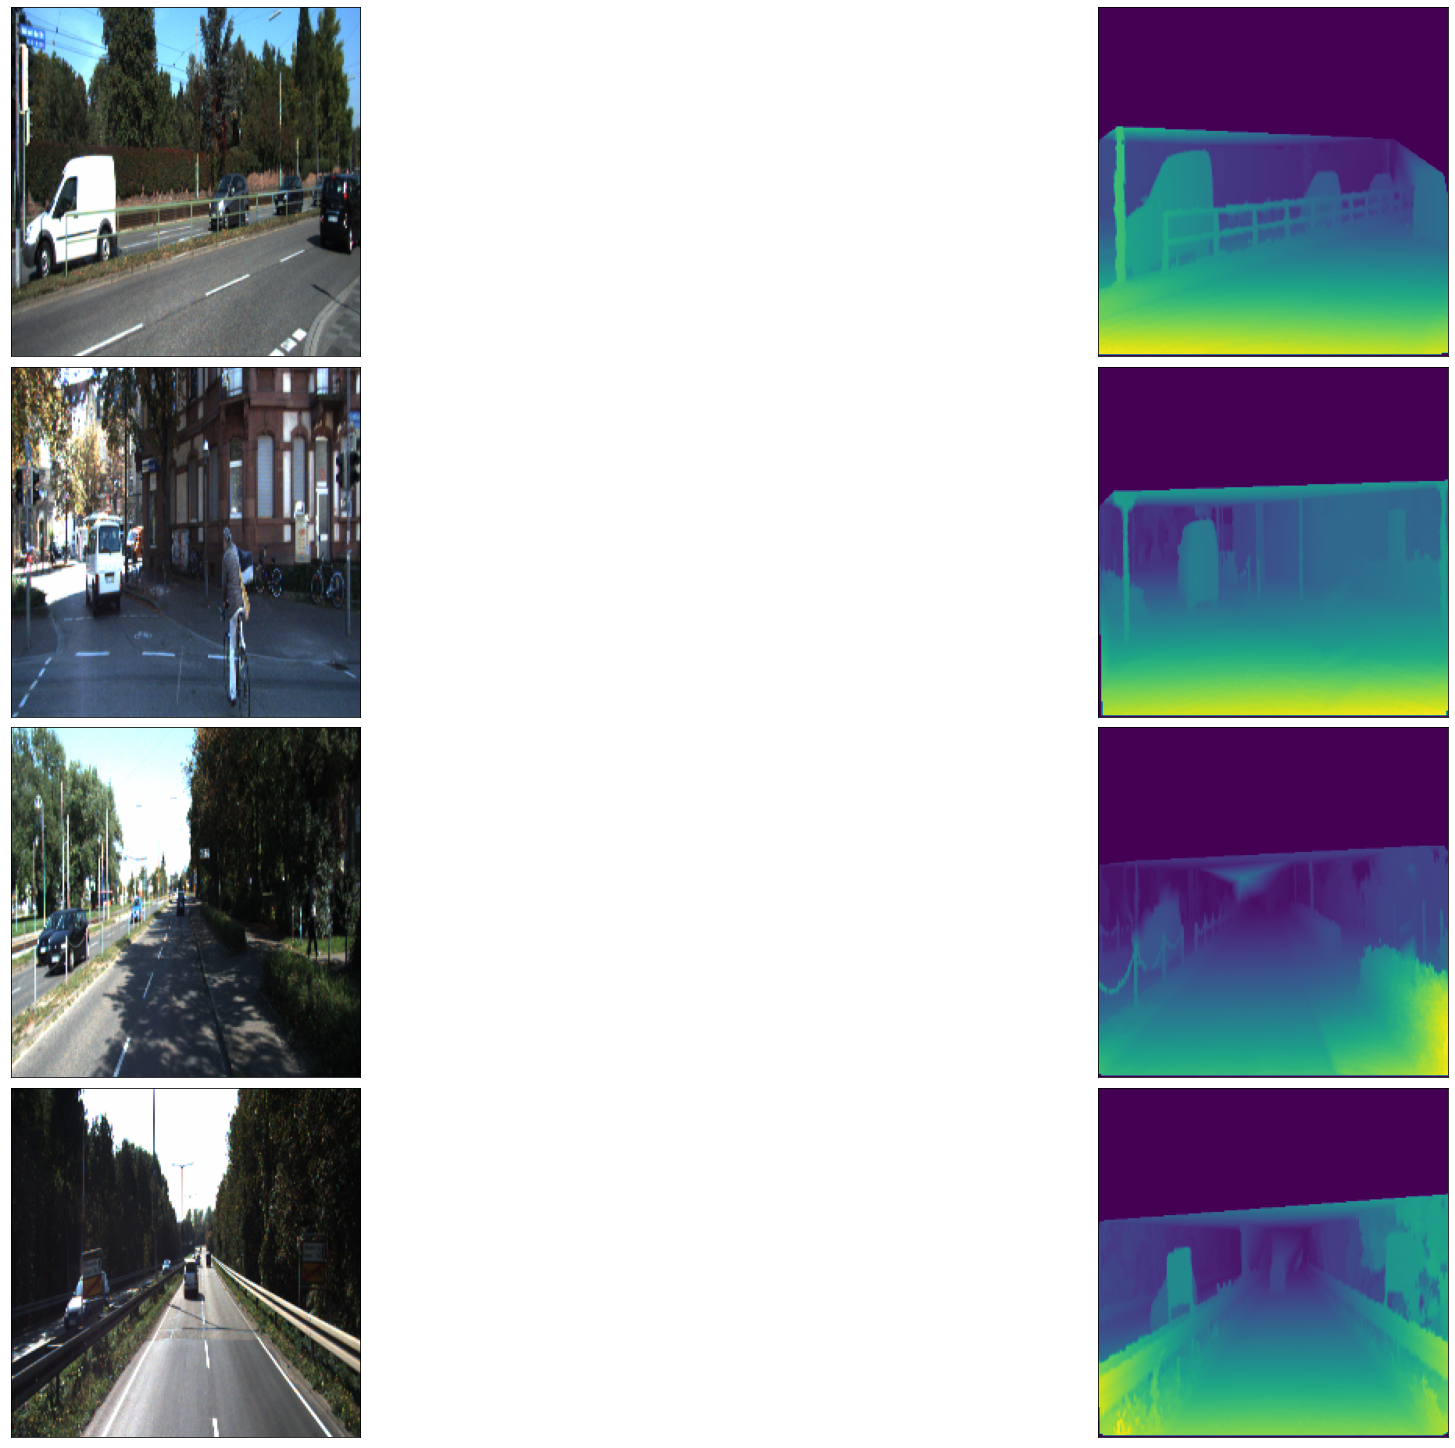

In [8]:
def visualise(samples, n_samples, test=False, model=None):
    x, y = samples 
    if test:
        pred = model.predict(x) 
        fig, ax = plt.subplots(n_samples, 3, figsize=(30, 20), constrained_layout=True)
        for i in range(n_samples):
            ax[i, 0].imshow((x[i]))
            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
            ax[i, 1].imshow((y[i]))
            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])
            ax[i, 2].imshow((pred[i])) 
            ax[i, 2].set_xticks([])
            ax[i, 2].set_yticks([])

    else:
        fig, ax = plt.subplots(n_samples, 2, figsize=(30, 20), constrained_layout=True)
        for i in range(n_samples):
            ax[i, 0].imshow((x[i]))
            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
            ax[i, 1].imshow((y[i]))
            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])

v_samples = next(iter(SupervisedDataGenerator(df=df, batch_size=4, dim=(WIDTH, HEIGHT))))

visualise(v_samples, n_samples = 4)

In [9]:
filters = [2**i for i in range(4, 9)]
filters

[16, 32, 64, 128, 256]

In [25]:
from depthEstimationLayers import * 

class DepthModel(tf.keras.Model):

    def __init__(self):
        super(DepthModel, self).__init__() 

        self.ssim_loss_weight = 0.85 
        self.l1_loss_weight = 0.1 
        self.edge_loss_weight = 0.9 
        self.loss_metric = tf.keras.metrics.Mean(name="loss") 
        filters = [2**i for i in range(4, 9)]
# EncodeLayer(f) for f in filters[:-1]
        self.Encoder = [
            EncodeLayer(filters[0]), 
            EncodeLayer(filters[1]),
            EncodeLayer(filters[2]),
            EncodeLayer(filters[3]) 
        ]
        self.BottleNeck = BottleNeck(filters[3])
        self.Decoder = [
            DecodeLayer(filters[3]),
            DecodeLayer(filters[2]),
            DecodeLayer(filters[1]),
            DecodeLayer(filters[0])
        ]
        
        self.conv = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calc_loss(self, y_true, y_pred):
        
        #Edges Loss 
        dy_t, dx_t = tf.image.image_gradients(y_true)
        dy_p, dx_p = tf.image.image_gradients(y_pred)
        w_x = tf.exp(tf.reduce_mean(tf.abs(dx_t)))
        w_y = tf.exp(tf.reduce_mean(tf.abs(dy_t)))

        #Depth Smoothness 
        sm_x = dx_p * w_x
        sm_y = dy_p * w_y 
        depth_smoothness = tf.reduce_mean(abs(sm_x)) + tf.reduce_mean(abs(sm_y)) 

        #Structureal Similarity Index 
        ssim = tf.reduce_mean(
            1 - tf.image.ssim(y_true, y_pred, max_val = WIDTH, filter_size=7, k1=0.01**2, k2=0.03**2)
        )

        #Pointwise depth 
        l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred)) 
        loss = (
            self.ssim_loss_weight*ssim + self.l1_loss_weight*l1_loss + self.edge_loss_weight*depth_smoothness
        )

        return loss 

    @property
    def metrics(self):
        return [self.loss_metric] 

    def train_step(self, batch):
        x, y = batch 

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.calc_loss(y, y_pred)
        
        grads = tape.gradient(loss, self.trainable_variables) 
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result()
        }

    def test_step(self, batch):
        x, y = batch 
        y_pred = self(x, training=False)
        loss = self.calc_loss(y, y_pred) 

        self.loss_metric.update_state(loss) 
        return {
            "loss": self.loss_metric.result()
        }
    
    def call(self, x):
        conv1, pool1 = self.Encoder[0](x)
        conv2, pool2 = self.Encoder[1](pool1)
        conv3, pool3 = self.Encoder[2](pool2) 
        conv4, pool4 = self.Encoder[3](pool3) 

        bottle = self.BottleNeck(pool4) 

        up1 = self.Decoder[0](bottle, conv4)
        up2 = self.Decoder[1](up1, conv3)
        up3 = self.Decoder[2](up2, conv2)
        up4 = self.Decoder[3](up3, conv1) 

        conv = self.conv(up4)
        return conv 

    def model(self):
        x = layers.Input(shape = [WIDTH, HEIGHT, 1])
        return models.Model(inputs = [x], outputs = self.call(x))


In [26]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
m = DepthModel()
m.model().summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
encode_layer_36 (EncodeLayer)   ((None, 224, 224, 16 2608        input_3[0][0]                    
__________________________________________________________________________________________________
encode_layer_37 (EncodeLayer)   ((None, 112, 112, 32 14144       encode_layer_36[0][1]            
__________________________________________________________________________________________________
encode_layer_38 (EncodeLayer)   ((None, 56, 56, 64), 55936       encode_layer_37[0][1]            
____________________________________________________________________________________________

In [29]:
op = tf.keras.optimizers.Adam(learning_rate=0.01)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 

model = DepthModel() 
model.compile(optimizer = op, loss = loss) 

train_loader = SupervisedDataGenerator(
    df[:350].reset_index(drop="true"), batch_size=4, dim=(WIDTH, HEIGHT)
)
val_loader = SupervisedDataGenerator(
    df[350:].reset_index(drop="true"), batch_size=4, dim=(WIDTH, HEIGHT)
)

hist = model.fit(train_loader, epochs = 10, validation_data = val_loader)


Epoch 1/10
88/88 [==============================] - 458s 5s/step - loss: 3.1712 - val_loss: 3.5999
Epoch 2/10
88/88 [==============================] - 233s 3s/step - loss: 3.1435 - val_loss: 3.3901
Epoch 3/10
88/88 [==============================] - 238s 3s/step - loss: 3.1670 - val_loss: 3.3504
Epoch 4/10
88/88 [==============================] - 234s 3s/step - loss: 3.1536 - val_loss: 3.4481
Epoch 5/10
88/88 [==============================] - 228s 3s/step - loss: 3.1414 - val_loss: 3.3752
Epoch 6/10
88/88 [==============================] - 230s 3s/step - loss: 3.1275 - val_loss: 3.3718
Epoch 7/10
88/88 [==============================] - 226s 3s/step - loss: 3.1523 - val_loss: 3.4208
Epoch 8/10
88/88 [==============================] - 232s 3s/step - loss: 3.1524 - val_loss: 3.3384
Epoch 9/10
62/88 [====================>.........] - ETA: 1:01 - loss: 3.1978

In [ ]:
#Rough Work Below

In [ ]:
class DataLoader:

    def __init__(self, data_paths, shuffle = True, batch_size = 32, d_type="training", test_split = 0.2):
        ''' 
            Initializing loader parameters. Unpacks paths to image and depth image directories, and lists images inside them. 
            
            shuffle: Whether or not to shuffle the data
            batch_size: How many images to return everytime getBatch() function is called 
            d_type: Nature of the DataLoader object. Can be "training" or "testing". For testing, we do not need to unpack the depth maps
            test_split: How many images to use for training and validation. 
        '''

        self.depth_left, self.depth_right, self.img_left, self.img_right = data_paths           
        self.shuffle = shuffle 
        self.batch_size = batch_size 
        self.d_type = d_type
        self.test_split = 0.2 
        self.data = {
            "depth_left": [], 
            "depth_right": [], 
            "img_left": [], 
            "img_right": [] 
        }
        self.data_paths = os.listdir(self.depth_right)
        self.data_size = len(self.data_paths)

    def getLens(self):
        ''' 
            To find how many images we have in each unpacked directory
        '''
        for c in list(self.data.keys()):
            print(c, ":", len(self.data[c]))

    def load_paths(self):
        ''' 
            Loads the address of each image
        '''
        if self.d_type == "training": 
            self.data["img_left"] = [os.path.join(self.img_left, i) for i in tqdm(self.data_paths, desc="Loading Stereo Left Training Images", ncols=100)]
            self.data["depth_left"] = [os.path.join(self.depth_left, i) for i in tqdm(self.data_paths, desc="Loading Stereo Left Training Depths", ncols=100)] 
            self.data["img_right"] = [os.path.join(self.img_right, i) for i in tqdm(self.data_paths, desc="Loading Stereo Right Training Images", ncols=100)]
            self.data["depth_right"] = [os.path.join(self.depth_right, i) for i in tqdm(self.data_paths, desc="Loading Stereo Right Training Depths", ncols=100)]  

        else:
            self.data["img_left"] = [os.path.join(self.img_left, i) for i in tqdm(self.data_paths, desc="Loading Stereo Left Test Images", ncols=100)]
            self.data["img_right"] = [os.path.join(self.img_right, i) for i in tqdm(self.data_paths, desc="Loading Stereo Right Test Images", ncols=100)]

    def load_img(self, img_path):
        ''' 
            Reads an image from the mentioned address, followed by scaling
        '''
        # img = tf.io.read_file(img_path)
        # img = tf.image.decode_png(img, channels=3) 
        # return img/256
        img = np.asarray(Image.open(img_path))/256.
        return img  

    # @tf.function
    def linear_interpolation(self, shape, xyd_img): 
        ''' 
            Linear interpolation for the sparse ground truth depth map. This gives a better view of the depth map.
        '''
        m, n = shape 
        ij, d = xyd_img[:, 1::-1], xyd_img[:, 2]
        f = scipy.interpolate.LinearNDInterpolator(ij, d, fill_value=0) 
        J, I = np.meshgrid(np.arange(n), np.arange(m))
        IJ = np.vstack([I.flatten(), J.flatten()]).T 
        disparity = f(IJ).reshape(shape) 
        return disparity 
    
    # @tf.function
    def load_depth(self, depth_path):
        ''' 
            Reads a depth image from the mentioned address, followed by linear interpolation. 
        '''
        depth_map = self.load_img(depth_path) 
        x, y = np.where(depth_map > 0) 
        d = depth_map[depth_map != 0] 
        xyd = np.stack((y, x, d)).T 
        gt = self.linear_interpolation(depth_map.shape, xyd) 
        return gt 

    def getBatch(self):
        ''' 
            Returns a batch of "batch_size" number of images. Will be called in the training loop for some n number of times per epoch. 
        '''
        indices = random.sample(range(0, self.data_size), self.batch_size) 
        data = {
            "img_left": [self.load_img(self.data["img_left"][i]) for i in indices], 
            "img_right": [self.load_img(self.data["img_right"][i]) for i in indices], 
            "depth_left": [self.load_depth(self.data["depth_left"][i]) for i in indices], 
            "depth_right": [self.load_depth(self.data["depth_right"][i]) for i in indices]
        }            
        return data 

In [ ]:
datagen = DataLoader(train_paths)
datagen.load_paths()

Loading Stereo Right Training Depths: 100%|███████████████████| 200/200 [00:00<00:00, 244494.55it/s]


In [ ]:
datagen.getLens()

depth_left : 200
depth_right : 200
img_left : 200
img_right : 200


In [ ]:
batch = datagen.getBatch()

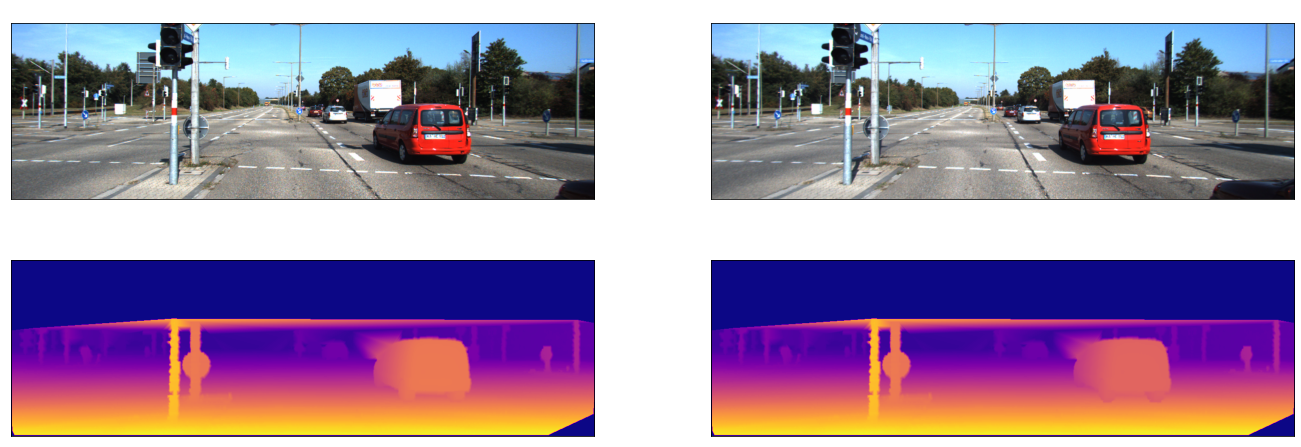

In [ ]:
# it_il = iter(batch["img_left"])
# it_ir = iter(batch["img_right"])
plt.figure(figsize=(23, 8))

plt.subplot(221)
plt.imshow(batch["img_left"][0])
plt.title("Image Left", color="white")
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(batch["depth_left"][0], cmap="plasma")
plt.title("Depth Left", color="white")
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.imshow(batch["img_right"][0])
plt.title("Image Right", color="white")
plt.xticks([])
plt.yticks([])

plt.subplot(224)
plt.imshow(batch["depth_right"][0], cmap="plasma")
plt.title("Depth Right", color="white")
plt.xticks([])
plt.yticks([])

plt.show()


In [ ]:
def linear_interpolation(shape, xyd):
    m, n = shape 
    ij, d = xyd[:, 1::-1], xyd[:, 2]
    f = scipy.interpolate.LinearNDInterpolator(ij, d, fill_value=0) 
    J, I = np.meshgrid(np.arange(n), np.arange(m))
    IJ = np.vstack([I.flatten(), J.flatten()]).T 
    disparity = f(IJ).reshape(shape) 
    return disparity 

def load_depth(img_path): 
    depth_map = np.asarray(Image.open(img_path))/256
    x, y = np.where(depth_map > 0)
    d = depth_map[depth_map != 0]
    xyd = np.stack((y, x, d)).T 
    gt = linear_interpolation(depth_map.shape, xyd)
    return gt 

In [ ]:
a = [1, 2, 3, 4, 5]
a[[4, 3, 2]]

TypeError: list indices must be integers or slices, not list

In [ ]:
left = os.listdir(train_depth_left)
right = os.listdir(train_depth_right)

In [ ]:
i1 = plt.imread(train_depth_left + "/" + left[1])
i2 = plt.imread(train_depth_right + "/" + right[1])

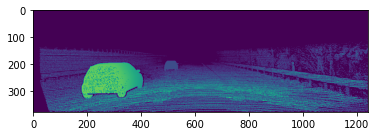

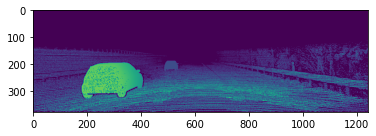

In [ ]:
plt.imshow(i1)
plt.show()
plt.imshow(i2)
plt.show()

In [ ]:
## Change this 
def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=np.uint16)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png / 255.
    depth[depth_png == 0] = -1.
    return depth


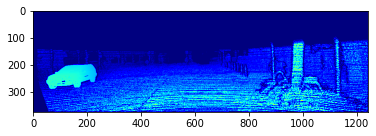

In [ ]:
img_path = "Datasets/stereo/data_scene_flow/training/disp_noc_0/000001_10.png"

img = depth_read(img_path)
plt.imshow(img, plt.cm.jet)
plt.show()

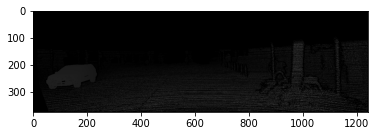

In [ ]:
img = cv2.imread(img_path)
plt.imshow(img, cmap=plt.cm.jet)
plt.show()

In [ ]:
img.shape

(375, 1242, 3)

In [ ]:
def normalize(img_path):
    img = cv2.imread(img_path)
    return img + (255 - img.max())
    

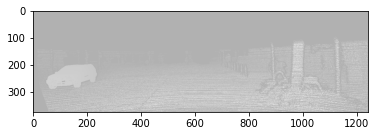

In [ ]:
plt.imshow(normalize(img_path))